# __packages__

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from spotify_api import SpotifyAPI

pickle_path_tracks = "./sampled_data/sampled_data_tracks_final.pickle"
pickle_path_track_artist = "./sampled_data/sampled_data_track_artist_final.pickle"

genre_list = [
    "rock",
    "hip hop",
    "pop",
    "jazz",
    "blues",
    "country",
    "metal",
    "reggae",
    "folk",
    "soul",
    "edm",
    "dance",
    "latin",
    "funk" 
]

---
# __data__

### 1) load source data (tracks and track_artist)
### 2) create dataframes by genres

In [2]:
tracks = pd.read_pickle(pickle_path_tracks)
tracks["other_genre"] = ~tracks.genres_combined.str.contains("(" + "|".join(genre_list) + ")")

track_artist = pd.read_pickle(pickle_path_track_artist)

df_list = []

for genre in genre_list:
    
    tmp = tracks.loc[tracks.genres_combined.str.contains(genre)]
    print(f"{genre} shape: {tmp.shape}")
    df_list.append((genre, tmp.copy()))
    
df_list.append(("other", tracks.loc[tracks.other_genre]))
print(f"other shape: {tracks.loc[tracks.other_genre].shape}")


/var/folders/9q/nynv72513xz5vlp8cpcm790r0000gn/T/ipykernel_48416/2682881059.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  tracks["other_genre"] = ~tracks.genres_combined.str.contains("(" + "|".join(genre_list) + ")")


rock shape: (16713, 29)
hip hop shape: (12782, 29)
pop shape: (34954, 29)
jazz shape: (1934, 29)
blues shape: (1057, 29)
country shape: (3360, 29)
metal shape: (4452, 29)
reggae shape: (3205, 29)
folk shape: (3348, 29)
soul shape: (3131, 29)
edm shape: (3084, 29)
dance shape: (7509, 29)
latin shape: (6220, 29)
funk shape: (1576, 29)
other shape: (27975, 29)


---
# __scaling__

### 1) scaling all features for each genre

In [3]:
col_list = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "time_signature",
    "valence"
]

scaled_features_list = []

for df_name, df in df_list:
    print(f"{df_name}")
    
    scaler_tmp = StandardScaler()
    
    scaler_source = df[col_list].to_numpy()
    scaler_tmp.fit(scaler_source)
    scaled_features_tmp = scaler_tmp.transform(scaler_source)
    
    scaled_features_list.append((df_name, copy.deepcopy(scaler_tmp), copy.deepcopy(scaled_features_tmp)))
    

rock
hip hop
pop
jazz
blues
country
metal
reggae
folk
soul
edm
dance
latin
funk
other


---

# __deciding the number of clusters__

### 1) plot SSE vs. the number of clusters, trying to find out the elbow point
### 2) elbow points are not clear, so set 110 clusters for the data that has over 10,000 rows and 60 clusters for the data that has below 10,000 rows

df_name: rock


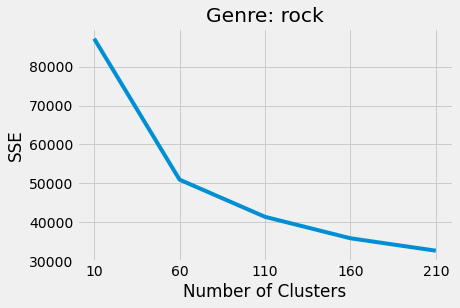

df_name: hip hop


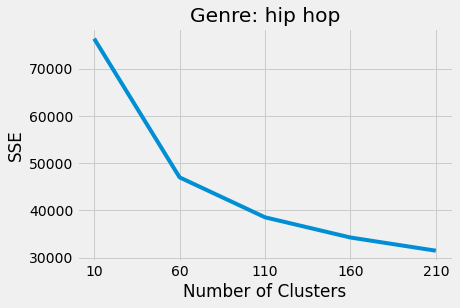

df_name: pop


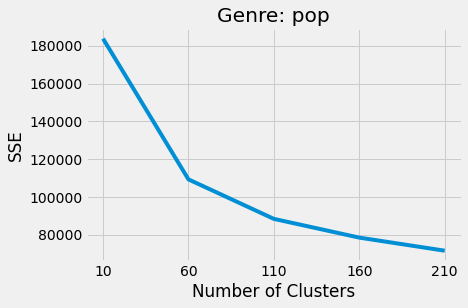

df_name: jazz


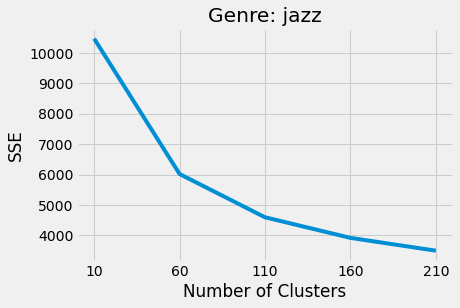

df_name: blues


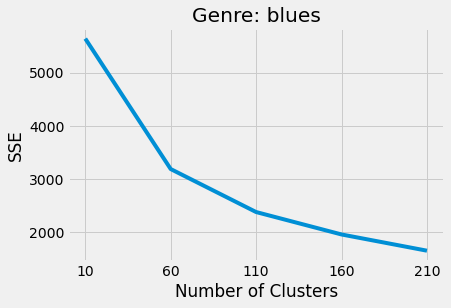

df_name: country


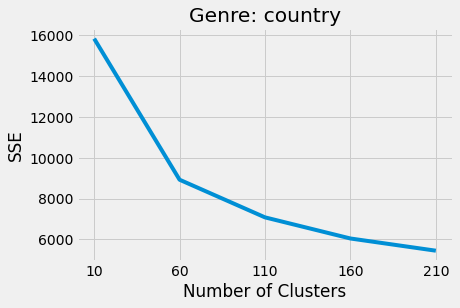

df_name: metal


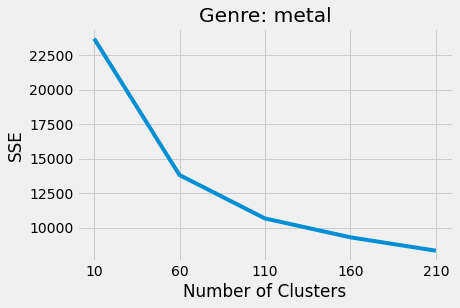

df_name: reggae


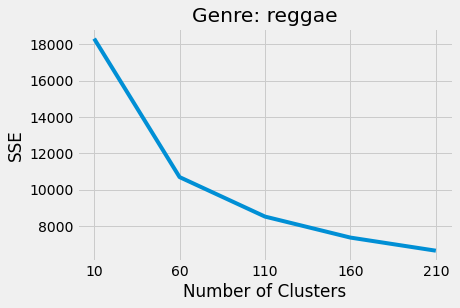

df_name: folk


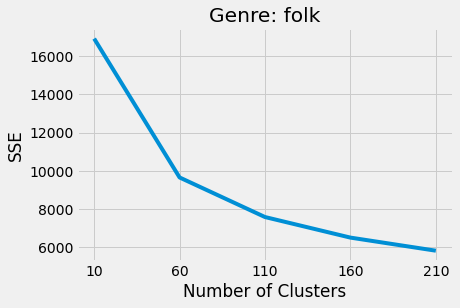

df_name: soul


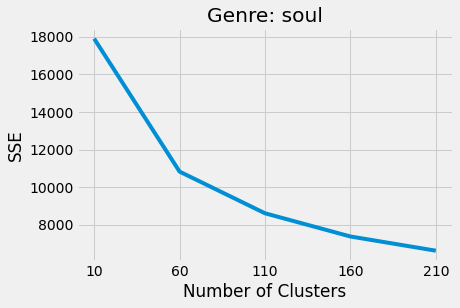

df_name: edm


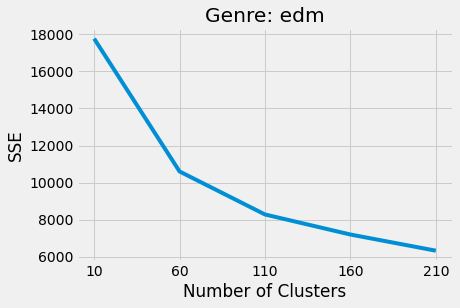

df_name: dance


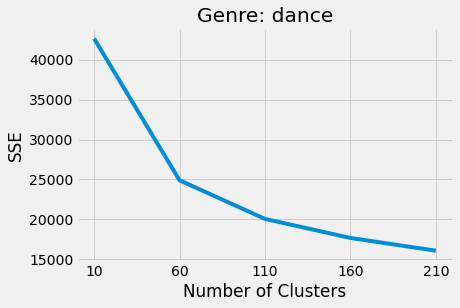

df_name: latin


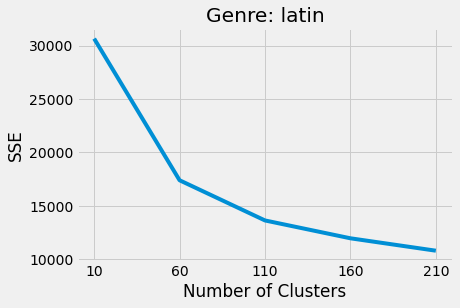

df_name: funk


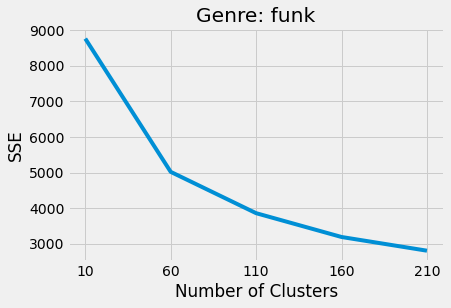

df_name: other


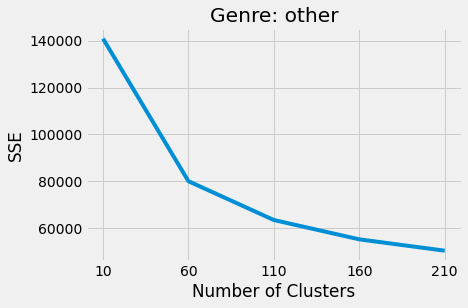

In [53]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2022,
}

# A list holds the SSE values for each k
plot_range = range(10, 250, 50)

for df_name, scaler, scaled_features in scaled_features_list:
    print(f"df_name: {df_name}")
    sse = []
    for k in plot_range:
        if k != 10:
            k = k - 10
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)


    plt.style.use("fivethirtyeight")
    plt.plot(plot_range, sse)
    plt.title(f"Genre: {df_name}")
    plt.xticks(plot_range)
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

In [4]:
k_parameter_list = []

for genre in genre_list + ["others"]:
    
    if genre in ["rock", "hip hop", "pop", "others"]:
        k_parameter_list.append((genre, 110))
    else:
        k_parameter_list.append((genre, 60))

display(k_parameter_list)

[('rock', 110),
 ('hip hop', 110),
 ('pop', 110),
 ('jazz', 60),
 ('blues', 60),
 ('country', 60),
 ('metal', 60),
 ('reggae', 60),
 ('folk', 60),
 ('soul', 60),
 ('edm', 60),
 ('dance', 60),
 ('latin', 60),
 ('funk', 60),
 ('others', 110)]

---
# __models__

### 1) build the final models for each genre

In [5]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2022,
}

kmeans_model_list = []

for genre, k in k_parameter_list:
    print(f"genre: {genre}, k: {k}")
    for df_name, scaler, scaled_features in scaled_features_list:
        if genre == df_name:
            
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(scaled_features)
            kmeans_model_list.append((genre, copy.deepcopy(kmeans)))

genre: rock, k: 110
genre: hip hop, k: 110
genre: pop, k: 110
genre: jazz, k: 60
genre: blues, k: 60
genre: country, k: 60
genre: metal, k: 60
genre: reggae, k: 60
genre: folk, k: 60
genre: soul, k: 60
genre: edm, k: 60
genre: dance, k: 60
genre: latin, k: 60
genre: funk, k: 60
genre: others, k: 110


---
# __test__

### 1) select 6 well-known songs, and assume we already knew ids of those songs
### 2) scrape information of those songs (tracks, audio-features, artists)
### 3) put songs into each model by genre, and assign the cluster
### 4) randomly recommend the one of the songs in the cluster (we used the fixed random state for reproducing the same results)

In [8]:
ids_list = [
    ("coldplay", "viva la vida", "1mea3bSkSGXuIRvnydlB5b"),
    ("taylor swift", "midnight rain", "1DAHLigfUqSLrU3RLG1EKR"),
    ("eminem", "8 mile", "2552neNWWQ2i2XZwPi5B3G"),
    ("eminem", "lose yourself", "77Ft1RJngppZlq59B6uP0z"),
    ("drake", "hotline bling", "0wwPcA6wtMf6HUMpIRdeP7"),
    ("jung kook", "dreamers", "1RDvyOk4WtPCtoqciJwVn8")
]

spotify = SpotifyAPI()
spotify.get_token()


response_tracks = spotify.get_query_by_ids("tracks", [tup[2] for tup in ids_list])
response_audio_features = spotify.get_query_by_ids("audio-features", [tup[2] for tup in ids_list])
artists_list = [track["artists"][0]["id"] for track in response_tracks["tracks"]]
response_artists = spotify.get_query_by_ids("artists", artists_list)


test_row_list = []

for tup, response_dict in zip(ids_list, response_audio_features["audio_features"]):
    tmp_dict = {}
    tmp_dict.update({"track_id": tup[-1], "track_name": tup[1], "artist": tup[0]})
    tmp_dict.update(response_dict)
    
    test_row_list.append(tmp_dict.copy())
    
test_df = pd.DataFrame(test_row_list)
test_df = test_df[["track_id", "track_name", "artist"] + col_list]

response status code: 200


In [9]:
artist_row_list = []

for tup, response_dict in zip(ids_list, response_artists["artists"]):
    tmp_dict = {}
    tmp_dict.update({"track_id": tup[-1]})
    tmp_dict.update({"genres_combined": ",".join(response_dict["genres"])})
    
    artist_row_list.append(tmp_dict.copy())
    
tmp_df = pd.DataFrame(artist_row_list)
test_df = pd.merge(test_df, tmp_df, how="left", on="track_id")

test_df["genre_list"] = test_df.genres_combined.str.findall("(" + "|".join(genre_list) + ")").apply(set)

display(test_df)


,track_id,track_name,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genres_combined,genre_list
0,1mea3bSkSGXuIRvnydlB5b,viva la vida,coldplay,0.09540,0.486,0.617,0.000003,0.1090,-7.115,0,0.0287,138.015,4,0.417,"permanent wave,pop",{pop}
1,1DAHLigfUqSLrU3RLG1EKR,midnight rain,taylor swift,0.72300,0.638,0.369,0.000053,0.1150,-11.711,1,0.0737,139.932,4,0.183,pop,{pop}
2,2552neNWWQ2i2XZwPi5B3G,8 mile,eminem,0.12500,0.740,0.940,0.000083,0.1320,-4.195,1,0.2850,89.981,4,0.489,"detroit hip hop,hip hop,rap",{hip hop}
3,77Ft1RJngppZlq59B6uP0z,lose yourself,eminem,0.00922,0.689,0.735,0.000720,0.3650,-4.545,1,0.2670,171.403,4,0.059,"detroit hip hop,hip hop,rap",{hip hop}
4,0wwPcA6wtMf6HUMpIRdeP7,hotline bling,drake,0.00258,0.891,0.628,0.000190,0.0504,-7.863,1,0.0551,134.966,4,0.552,"canadian hip hop,canadian pop,hip hop,rap,toro...","{pop, hip hop}"
5,1RDvyOk4WtPCtoqciJwVn8,dreamers,jung kook,0.15800,0.710,0.879,0.001420,0.4390,-4.218,1,0.0422,114.993,4,0.341,k-pop,{pop}


In [9]:
test_scaled_features_list = []

for i, row in test_df.iterrows():
    
    for genre in row["genre_list"]:
        
        for df_name, scaler, scaled_features in scaled_features_list:
            
            if genre == df_name:
                scaled_features_tmp = scaler.transform(row[col_list].to_numpy().reshape(1, -1))
                test_scaled_features_list.append((genre, copy.deepcopy(scaled_features_tmp)))


In [10]:
predicted_list = []

for genre, scaled_feature in test_scaled_features_list:
    
    for df_name, kmeans in kmeans_model_list:
        
        if genre == df_name:
            predicted_list.append((genre, kmeans.predict(scaled_feature)[0]))

In [11]:
concat_list = []
random_state = 2022

for predicted in predicted_list:
    
    genre_df = [df for genre, df in df_list if genre == predicted[0]]
    kmeans_model = [kmeans for genre, kmeans in kmeans_model_list if genre == predicted[0]]

    concat_list.append(copy.deepcopy(genre_df[0].iloc[np.where(kmeans_model[0].labels_ == predicted[1])].sample(1, random_state=random_state)))
    
final = pd.concat(concat_list)

display(final)

,track_id,album_id,disc_number,duration_ms,explicit,track_name,album_popularity,track_number,duration_m,release_date,...,speechiness,tempo,time_signature,valence,genres,artist_popularity,genres_combined,artist_name_combined,artist_popularity_max,other_genre
105533,7fzkwV4lfFdaImzLLRarA3,4ZViAZBx7M4vleeGgaNSMI,1,275440,False,Wolf & I,34,6,4.590667,2011-03-11,...,0.0363,134.754,4,0.101,"[electropop, metropopolis]",39,"electropop,metropopolis",Oh Land,39,False
69879,4xHkj5OuwbhJ3VhbW09Xxt,3vcFOmCrmZnXeyx7gJ8L1s,1,200981,False,A Escondidas,37,11,3.349683,2017-04-28,...,0.0283,131.968,4,0.210,"[latin arena pop, mexican pop, sonora indie]",46,"latin arena pop,mexican pop,sonora indie",Lucah,46,False
94439,6glFKVBWmop3Aw8jEIF0hd,2cXsxv2Z8rLDV96vjTDGcb,1,186163,False,Gladiator,32,3,3.102717,2016-07-29,...,0.0681,124.907,4,0.477,"[post-teen pop, social media pop]",43,"post-teen pop,social media pop",The Girl and The Dreamcatcher,43,False
22443,1apVaGOr4BUgSdWG81CIv4,3UCtCwB9nl9meUYM52Z8t5,1,179534,True,Chanson française,44,8,2.992233,2015,...,0.4060,87.004,4,0.796,"[francoton, french hip hop, pop urbaine, rap c...",55,"francoton,french hip hop,pop urbaine,rap consc...",Youssoupha,55,False
50958,3buQGKqVsWEaYibrbViaCx,2Qvup4Tfqt5r7icH44mx9s,1,179612,True,Magazine,32,7,2.993533,2016-06-17,...,0.3220,155.193,4,0.240,"[deep underground hip hop, kentucky hip hop, p...",81,"deep underground hip hop,kentucky hip hop,pop,rap",Jack Harlow,81,False
90787,6RI55EbhlxnXhOK27AI8WZ,2q0B1JTgZRAh7xVEZfJRg8,1,171853,True,Erica Kane,44,5,2.864217,2014-09-02,...,0.0445,136.892,4,0.615,"[melodic rap, south carolina hip hop, southern...",52,"melodic rap,south carolina hip hop,southern hi...",Speaker Knockerz,52,False
95427,6l5EnqPcPqQJluoJaT9z3f,3j8iyHi0RxqLLV97ZGOCPm,1,211400,False,Magudi Magudi,43,7,3.523333,2012-12-14,...,0.0968,120.050,4,0.636,"[desi pop, filmi, modern bollywood]",79,"desi pop,filmi,modern bollywood,filmi,filmi,ma...","A.R. Rahman,Tanvi Shah,Chinmayi",79,False
47366,3Mbvwfcmfr4k0yYtMatnsA,2ESc204TZmoBLPDfqNVYFY,1,221585,False,Penge Kommer Går,34,6,3.693083,2015-05-18,...,0.0413,129.946,4,0.218,"[danish hip hop, danish pop]",65,"danish hip hop,danish pop",Gilli,65,False


# __result__


### Sounds similar:
### Midnight Rain by Taylor Swift & Rumors by Adam Labmert (pop)
### Lose Yourself by Eminem & Get Mine by Yelawolf (hip hop)
### Dreamers by Jung Kook & Te Bese by Leonel Garcia